In [113]:
import os
import re
import pickle
import spacy
import datetime
import pandas as pd

from tqdm import tqdm

In [2]:
processed_dir = r'D:\data\kaggle_news\processed'
news_text_pklfile = 'dic_all_news_text.pkl'

In [123]:
df_basel_risk_norms = pd.read_csv('risk_mean_basel_risk_norms.csv')
lst_BRN_lower = [x.strip().lower() for x in df_basel_risk_norms.source]

In [124]:
df_basel_risk_norms.index =lst_BRN_lower
df_basel_risk_norms.head()

,source,rating
america,America,8.921053
antarctic,Antarctic,38.099338
australia,Australia,-25.805195
boston,Boston,-14.824324
california,California,-21.959184


In [125]:
df_basel_risk_norms.loc['america','rating']

8.921052631578947

In [3]:
dic_news_text = pickle.load(open(os.path.join(processed_dir, news_text_pklfile), 'rb'))

In [8]:
nlp = spacy.load('en_core_web_lg')

<b> (Caution) Below for loop takes 5 hours. Use dic_rick_word_in_news.pkl file! </b>

In [17]:
riskword_news_file = 'dic_risk_word_in_news.pkl'

if os.path.exists(riskword_news_file):
    print(f'Loading {riskword_news_file} ...')
    dic_risk_word_in_news = pickle.load(open(riskword_news_file, 'rb'))
else:
    dic_risk_word_in_news = {}
    for uuid, dic_text in tqdm(dic_news_text.items()):
        news_text = dic_text['text']
        # split text into words using re
        doc = nlp(news_text)
        tokens = [token for token in doc]
        lemma_lower = [token.lemma_.lower() for token in tokens]
        risk_words = [x for x in lemma_lower if x in lst_BRN_lower]
        if len(risk_words) > 0:
            dic_risk_word_in_news[uuid] = risk_words

100%|██████████| 306188/306188 [5:14:02<00:00, 16.25it/s]   


In [18]:
if not os.path.exists(riskword_news_file):
    pickle.dump(dic_risk_word_in_news, open(riskword_news_file, 'wb'))

In [114]:
len(dic_risk_word_in_news)

253887

In [20]:
news_meta_file = 'dic_all_news.pkl'
dic_news_meta = pickle.load(open(os.path.join(processed_dir, news_meta_file), 'rb'))

In [21]:
first_key = next(iter(dic_news_meta))

In [23]:
dic_news_meta[first_key]

{'organizations': [],
 'author': '',
 'url': 'https://www.cnbc.com/2018/01/03/emerging-markets-are-set-for-an-even-bigger-rally-in-2018-says-one-technician.html',
 'ord_in_thread': 0,
 'title': 'Emerging markets are set for an even bigger rally in 2018, says one technician',
 'locations': [],
 'highlightText': '',
 'language': 'english',
 'persons': [],
 'external_links': [],
 'published': '2018-01-03T15:00:00.000+02:00',
 'crawled': '2018-01-03T15:34:36.006+02:00',
 'highlightTitle': '',
 'word_cnt': 303}

In [24]:
dic_uuid_pubdate = {key: val['published'] for key, val in dic_news_meta.items()}

In [25]:
len(dic_uuid_pubdate)

306188

In [27]:
df_pubdate = pd.Series(dic_uuid_pubdate)
df_risk = pd.Series(dic_risk_word_in_news)
df_all = pd.concat([df_pubdate, df_risk], axis=1)
df_all.columns = ['pubdate', 'risk_word']
df_all.set_index('pubdate', inplace=True, drop=True)
df_all.index = pd.PeriodIndex(df_all.index, freq='D')
df_all.reset_index(inplace=True)
df_all.head(10)

In [60]:
def get_risk_word(text):
    if isinstance(text, list):
        return int(len(text))
    return text

df_all['num_words'] = df_all['risk_word'].apply(lambda x: get_risk_word(x))

In [115]:
df_all.head()

,pubdate,risk_word,num_words
0,2018-01-03,"[relationship, fall]",2.0
1,2018-01-03,[fuel],1.0
2,2018-01-03,"[people, people, facebook]",3.0
3,2018-01-02,"[television, fire, orange, fire, winter, olymp...",9.0
4,2018-01-01,"[death, death, pilot, crash, australia]",5.0


In [126]:
def get_risk_word_score(text):
    
    if isinstance(text, list):
        score = sum([df_basel_risk_norms.loc[x, 'rating'] for x in text])
        return score
    return text

df_all['risk_score'] = df_all['risk_word'].apply(lambda x: get_risk_word_score(x))


In [127]:
df_all.head()

,pubdate,risk_word,num_words,risk_score
0,2018-01-03,"[relationship, fall]",2.0,11.130559
1,2018-01-03,[fuel],1.0,11.087248
2,2018-01-03,"[people, people, facebook]",3.0,15.191310
3,2018-01-02,"[television, fire, orange, fire, winter, olymp...",9.0,-58.508678
4,2018-01-01,"[death, death, pilot, crash, australia]",5.0,181.628126


In [137]:
df_all2 = df_all.dropna().sort_index()
df_all2 = df_all2.groupby('pubdate').agg({'num_words':['sum','count'],'risk_score':'sum'})

In [138]:
df_all2.columns = df_all2.columns.to_flat_index()

In [141]:
df_all2.head()

,"(num_words, sum)","(num_words, count)","(risk_score, sum)"
pubdate,,,
2017-12-07,70.0,3,434.339784
2017-12-08,36.0,3,-511.497280
2017-12-10,1.0,1,-45.235294
2017-12-13,2.0,1,-5.473070
2017-12-14,4.0,2,-175.146273


In [63]:
import pandas_datareader as pdr

In [142]:
start = datetime.datetime(2018,1,1)
end = datetime.datetime(2018,5,31)
vix = pdr.DataReader('VIXCLS', 'fred', start, end).dropna()

In [143]:
vix.index = pd.PeriodIndex(vix.index, freq='D')
df_all3 = pd.merge(df_all2, vix, how='outer', left_index=True, right_index=True)
df_all3 = df_all3.loc['2018-01-01':]
df_all3.ffill().bfill(inplace=True)

#### Questions
- Word cleaning?
- Apply Risk score
- Number of news by date -> normalise

In [144]:
df_all3['mean_risk_score'] = df_all3[('risk_score','sum')] / df_all3[('num_words', 'count')]

In [145]:
df_all3.head()

,"(num_words, sum)","(num_words, count)","(risk_score, sum)",VIXCLS,mean_risk_score
2018-01-01,3448.0,258,15514.807864,NaN,60.134914
2018-01-02,11620.0,1069,-40505.858346,9.77,-37.891355
2018-01-03,15200.0,1393,-68785.290803,9.15,-49.379247
2018-01-04,19908.0,1659,-91354.238121,9.22,-55.065846
2018-01-05,17051.0,1435,-105114.941009,9.22,-73.250830


In [146]:
df_all3[['mean_risk_score', 'VIXCLS']].corr()

,mean_risk_score,VIXCLS
mean_risk_score,1.000000,-0.009935
VIXCLS,-0.009935,1.000000


<Axes: >

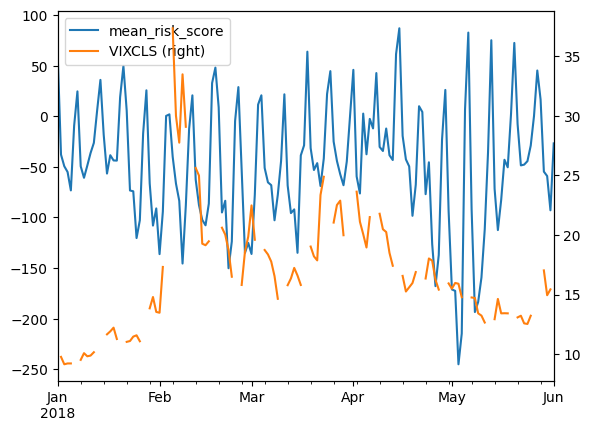

In [149]:
df_all3[['mean_risk_score', 'VIXCLS']].plot(style='-',secondary_y='VIXCLS')